In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Hyperparameters

In [2]:
np.random.seed(1234)

# The size of the dataset
N = 100

# The order of polynomial function
M = 4

# The precision of the weight prior distribution
alpha = 1e-3

# the precision of the data
beta = 20


### 2. dataset generation

In [3]:
def generate_dataset(N):
    
    '''
    arguments로 주어진 N개 크기의 dataset을 만듭니다.

    arguments
    N: scalar, data point 갯수

    returns
    x: (N), input values
    y: (N), noiseless output values
    t: (N), target values

    '''

    # 0부터 0.3까지 N/2개, 0.7부터 1까지 N/2개의 값을 얻습니다.
    x = np.concatenate([np.linspace(0, 0.3, N//2), np.linspace(0.7, 1, N//2)])

    # sin(2πx)
    y = np.sin(2*np.pi*x)
    
    # Normal(mean=0, stddev=0.2) error term
    error = 0.2 * np.random.randn(N)
    t = y + error
    
    return x, y, t

x, y, t = generate_dataset(N)


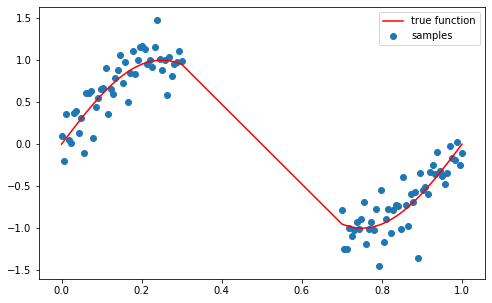

In [4]:
# Visualization
plt.figure(figsize=[8, 5])
plt.scatter(x, t, label='samples')
plt.plot(x, y, label='true function', color='red')
plt.legend()
plt.show()


### 3. Design Matrix



In [5]:
def generate_design_matrix(x, M):
    '''
    polynomial basis function을 적용한 design matrix를 만듭니다.

    arguments
    x: (N), input data
    M: scalar, the order of polynomial basis function

    returns
    Phi: (N, M), design matrix
    '''

    Phi = []
    for m in range(M):
        Phi.append(x ** m) # m-order polynomial
        
    # list to numpy array
    Phi = np.stack(Phi, axis=1)
    
    return Phi

# Design Matrix, shape : [N, M]
Phi = generate_design_matrix(x, M)


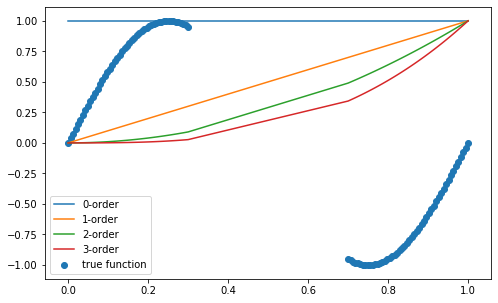

In [6]:
# Visualization
plt.figure(figsize=[8, 5])
plt.plot(x, Phi[:, 0], label='0-order')
plt.plot(x, Phi[:, 1], label='1-order')
plt.plot(x, Phi[:, 2], label='2-order')
plt.plot(x, Phi[:, 3], label='3-order')
plt.scatter(x, y, label='true function')
plt.legend()
plt.show()


### 4. Find the weight posterior distribution

$p(\mathbf{w} | \mathbf{t})=\mathcal{N}\left(\mathbf{w} | \mathbf{m}_{N}, \mathbf{S}_{N}\right)$, where 
$\begin{aligned}
&\mathbf{m}_{N}=\beta \mathbf{S}_{N} \mathbf{\Phi}^{\mathrm{T}} \mathbf{t}\\
&\mathbf{S}_{N}^{-1}=\alpha \mathbf{I}+\beta \mathbf{\Phi}^{\mathrm{T}} \mathbf{\Phi}
\end{aligned}$

In [7]:
def find_posterior(alpha, beta, Phi, t):
    
    '''
    weight의 posterior distribution을 구합니다.
    
    arguments
    alpha: scalar, the precision of the weight prior distribution
    beta: scalar, the precision of the data
    Phi: (N, M), design matrix
    t: (N), target values

    returns
    m_N: (M), the mean of the posterior
    S_N: (M, M), the covariance matrix of the posterior
    '''
    
    # Inverse of the covariance
    S_N_inverse = alpha * np.eye(Phi.shape[1]) + beta * Phi.T @ Phi
    S_N = np.linalg.inv(S_N_inverse)

    # Mean 
    m_N = beta * S_N @ Phi.T @ t
    return m_N, S_N

m_N, S_N = find_posterior(alpha, beta, Phi, t)


### 5. Find the predictive distribution

$\begin{aligned}
p(t | \mathbf{x}, \mathbf{t}, \alpha, \beta) &=\mathcal{N}\left(t | \mathbf{m}_{N}^{\mathrm{T}} \boldsymbol{\phi}(\mathbf{x}), \sigma_{N}^{2}(\mathbf{x})\right) \\
& \text { where } \sigma_{N}^{2}(\mathbf{x})=\frac{1}{\beta}+\boldsymbol{\phi}(\mathbf{x})^{\mathrm{T}} \mathbf{S}_{N} \boldsymbol{\phi}(\mathbf{x})
\end{aligned}$

In [8]:
def find_predictive(beta, m_N, S_N, phi):
    
    '''
    predictive distribution을 구합니다.
    
    arguments
    beta: scalar, the precision of the data
    m_N: (M), the mean of the posterior
    S_N: (M, M), the covariance matrix of the posterior
    phi: (M), a row of the design matrix (a preprocessed input)

    returns
    mean: scalar, the mean of the predictive distribution
    stddev: scalar, the standard deviation of the predictive distribution
    
    '''
    
    mean = m_N @ phi
    variance = 1 / beta + phi @ S_N @ phi
    stddev = variance ** 0.5
    
    return mean, stddev


In [9]:
x_new = np.linspace(-0.1, 1.1, 1000)
Phi_new = generate_design_matrix(x_new, M)

# the array of predictives: (N, 2)
predicted = np.array([find_predictive(beta, m_N, S_N, phi) for phi in Phi_new])
# (N)
mean_pred = predicted[:, 0]
# (N)
stddev_pred = predicted[:, 1]


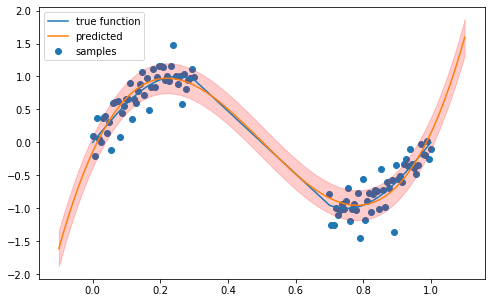

In [10]:
# Visualization
plt.figure(figsize=[8, 5])
plt.plot(x, y, label='true function')
plt.scatter(x, t, label='samples')
plt.plot(x_new, mean_pred, label='predicted')
plt.fill_between(x_new, mean_pred-stddev_pred, mean_pred+stddev_pred, color='red', alpha=0.2)
plt.legend()
plt.show()


### 왜 prediction이 제대로 안되고 있는지 생각해봅시다. 

1. N을 작게(1) 또는 크게(10000) 만들어서 다시 구해봅시다.

2. prior precision인 alpha를 작게 또는 크게 만들어서 다시 구해봅시다.

3. data precision인 beta를 작게 또는 크게 만들어서 다시 구해봅시다.

### 6. Find the hyperparameters $\alpha, \beta$ by maximizing the marginal likelihood of the dataset

$\begin{aligned}
&\alpha=\frac{\gamma}{\mathbf{m}_{N}^{\mathrm{T}} \mathbf{m}_{N}}\\
&\frac{1}{\beta}=\frac{1}{N-\gamma} \sum_{n=1}^{N}\left\{t_{n}-\mathbf{m}_{N}^{\mathrm{T}} \boldsymbol{\phi}\left(\mathbf{x}_{n}\right)\right\}^{2}\\
&\gamma=\sum_{i} \frac{\lambda_{i}}{\alpha+\lambda_{i}}, \text { where } \lambda_{i} \text { are eigenvalues of } \beta \mathbf{\Phi}^{\mathrm{T}} \mathbf{\Phi}
\end{aligned}$

In [11]:
def find_alpha_beta(m_N, t, Phi, gamma):
    '''
    log marginal likelihood를 최대화하는 alpha와 beta를 구합니다.
    
    arguments
    t: (N), target values
    Phi: (N, M), design matrix
    gamma: scalar, the auxilary value for training

    returns
    alpha: scalar, the precision of prior
    beta: scalar, the precision of data
    
    '''
    alpha = gamma / (m_N @ m_N)
    beta = (N - gamma) / np.sum((t - Phi @ m_N) ** 2)
    
    return alpha, beta

def find_gamma(alpha, eigenvalues):
    '''
    log marginal likelihood를 최대화하는 gamma를 구합니다.
    
    arguments
    alpha: scalar, the precision of prior
    eigenvalues: (M), the eigen values of beta * Phi.T @ Phi

    returns
    gamma: scalar, the auxilary value for training 
    
    '''
    gamma = np.sum(eigenvalues / (alpha + eigenvalues))
    
    return gamma

def train_hyperparams(alpha, beta, Phi, t, step=10, gamma=1, verbose=True):
    
    '''
    log marginal likelihood를 최대화하는 alpha와 beta를 구하기 위해 iteration을 수행합니다.
    
    arguments
    alpha: scalar, the initial precision of prior
    beta: scalar, the initial precision of data
    Phi: (N, M), design matrix
    t: (N), target values
    step: steps for iteration
    gamma: the auxilary value for training 

    returns
    alpha: scalar, the precision of prior
    beta: scalar, the precision of data
    '''

    eigenvalues, _ = np.linalg.eig(beta * Phi.T @ Phi)

    for i in range(step):
        m_N, S_N = find_posterior(alpha, beta, Phi, t)
        gamma = find_gamma(alpha, eigenvalues)
        alpha, beta = find_alpha_beta(m_N, t, Phi, gamma)      
        if verbose:
            print('step ' + str(i))
            print('α :', alpha, 'β :', beta)
    
    return alpha, beta

alpha_trained, beta_trained = train_hyperparams(alpha, beta, Phi, t)
m_N, S_N = find_posterior(alpha_trained, beta_trained, Phi, t)

# the array of predictives: (N, 2)
predicted = np.array([find_predictive(beta_trained, m_N, S_N, phi) for phi in Phi_new])
mean_pred = predicted[:, 0]
stddev_pred = predicted[:, 1]    

var_pred = 1 / beta_trained + np.sum(Phi_new @ S_N * Phi_new, axis=1)
stddev_pred = np.sqrt(var_pred)

step 0
α : 0.002410073878991156 β : 21.063909981797494
step 1
α : 0.0024316149712976516 β : 21.058704007241886
step 2
α : 0.002431970929913429 β : 21.058576586057093
step 3
α : 0.0024319769023756444 β : 21.05857443705297
step 4
α : 0.002431977002609359 β : 21.058574400983943
step 5
α : 0.002431977004289601 β : 21.058574400379303
step 6
α : 0.002431977004314935 β : 21.0585744003702
step 7
α : 0.0024319770043194646 β : 21.0585744003686
step 8
α : 0.0024319770043172207 β : 21.0585744003694
step 9
α : 0.002431977004316809 β : 21.058574400369512


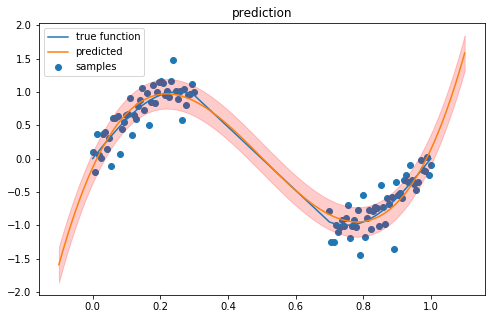

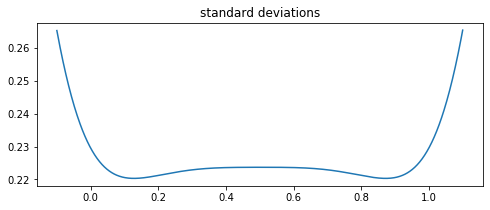

In [12]:
# Visualization
plt.figure(figsize=[8, 5])
plt.plot(x, y, label='true function')
plt.scatter(x, t, label='samples')
plt.plot(x_new, mean_pred, label='predicted')
plt.fill_between(x_new, mean_pred-stddev_pred, mean_pred+stddev_pred, color='red', alpha=0.2)
plt.legend()
plt.title('prediction')
plt.show()

plt.figure(figsize=[8, 3])
plt.plot(x_new, stddev_pred)
plt.title('standard deviations')
plt.show()

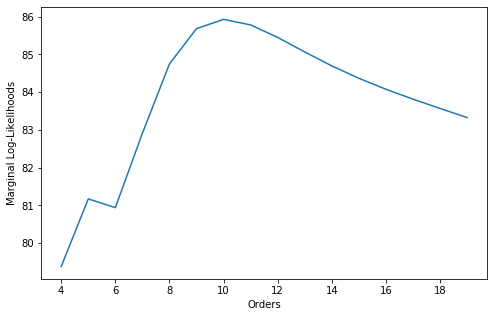

In [13]:
def find_log_marginal_likelihood(M, alpha, beta, Phi, t, m_N):
    
    ll = M / 2 * np.log(alpha)
    ll += N / 2 * np.log(beta)
    E_m_N = beta / 2 * np.sum((t - Phi @ m_N)**2) + alpha / 2 * m_N @ m_N
    ll -= E_m_N
    A = alpha * np.eye(M) + beta * Phi.T @ Phi
    logdet = np.log(np.linalg.det(A))
    ll -= 0.5 * logdet
    ll - N / 2 * np.log(2 * np.pi)
    
    return ll

def bayesian_linear_regression(M, x, t):
    alpha = 1e-2
    beta = 20
    
    Phi = generate_design_matrix(x, M)
    m_N, S_N = find_posterior(alpha, beta, Phi, t)
    ll = find_log_marginal_likelihood(M, alpha, beta, Phi, t, m_N)
    
    return ll

orders = [i for i in range(4, 20)]
ll_list = []
for m in orders:
    ll = bayesian_linear_regression(m, x, t)
    ll_list.append(ll)

plt.figure(figsize=[8, 5])
plt.plot(orders, ll_list)
plt.ylabel('Marginal Log-Likelihoods')
plt.xlabel('Orders')
plt.show()
    